In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import trident
import chollaread
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as colors
import colorcet as cc
from matplotlib.cm import get_cmap
from astropy.constants import M_sun
import matplotlib.axes

/Users/sofimar/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:768: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
ds = chollaread.load('/Users/sofimar/Desktop/Summer Research/140.h5.0',cell_size_cgs=(10/256)*chollaread.kpc)

yt : [INFO     ] 2022-07-15 18:31:50,106 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-07-15 18:31:50,109 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2022-07-15 18:31:50,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-15 18:31:50,110 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22]
yt : [INFO     ] 2022-07-15 18:31:50,114 Parameters: cosmological_simulation   = 0.0


In [3]:
def make_ray(x0, y0, z0, x, y, z, num):
    
    k = (3.086E+21)*10 # Code length
    
    ray_start = np.array([x0,y0,z0])*k
    ray_end = np.array([x,y,z])*k
    
    ray = trident.make_simple_ray(ds,
                                 start_position=ray_start,
                                 end_position=ray_end,
                                 data_filename= 'ray_'+str(num)+'.h5',
                                 lines='all',
                                 ftype='gas')
    return ray

In [37]:
def cut_spec(ray_, lmin, lmax, num, dlam=0.001, line=None, el=None, rom_num=None, 
             lrest=None, gamma=None, f_value=None, DIY=False):
    
    k = (3.086E+21)*10 # Code length
    cu = 1/256
    
    arrays = []
    ray = ray_
    all_data = ray.all_data()
  
    cold_gas = ray.cut_region(all_data, 'obj["gas", "temperature"] < 20000')
    cold_gas2 = ray.cut_region(all_data, 'obj["gas", "temperature"] < 50000')
    
    int_gas = ray.cut_region(all_data, 
                             ['obj["gas", "temperature"] > 20000' , 'obj["gas", "temperature"] < 500000'])
    int_gas2 = ray.cut_region(all_data, 
                             ['obj["gas", "temperature"] > 50000' , 'obj["gas", "temperature"] < 500000'])
    
    hot_gas = ray.cut_region(all_data, 'obj["gas", "temperature"] > 500000')
                            
    
    sg = trident.SpectrumGenerator(lambda_min= lmin, lambda_max= lmax, dlambda=dlam)
    
    if DIY==True:

        DIY_line = el+' '+str(rom_num)+' '+str(int(lrest))
        sg.add_line_to_database(el, rom_num, lrest, gamma,f_value, field=None,
                                identifier=DIY_line)

        sg.make_spectrum(all_data, lines=[DIY_line])
        sg.save_spectrum('spec.txt')
        
        sg.make_spectrum(cold_gas, lines=[DIY_line])
        sg.save_spectrum('spec_c.txt')
        sg.make_spectrum(cold_gas2, lines=[DIY_line])
        sg.save_spectrum('spec_c2.txt')
        
        sg.make_spectrum(int_gas, lines=[DIY_line])
        sg.save_spectrum('spec_i.txt')
        sg.make_spectrum(int_gas2, lines=[DIY_line])
        sg.save_spectrum('spec_i2.txt')
        
        sg.make_spectrum(hot_gas, lines=[DIY_line])
        sg.save_spectrum('spec_h.txt')
        
    else:
        sg.make_spectrum(all_data, lines=[line])
        sg.save_spectrum('spec.txt')
        
        sg.make_spectrum(cold_gas, lines=[line])
        sg.save_spectrum('spec_c.txt')
        sg.make_spectrum(cold_gas2, lines=[line])
        sg.save_spectrum('spec_c2.txt')
        
        sg.make_spectrum(int_gas, lines=[line])
        sg.save_spectrum('spec_i.txt')
        sg.make_spectrum(int_gas2, lines=[line])
        sg.save_spectrum('spec_i2.txt')
        
        sg.make_spectrum(hot_gas, lines=[line])
        sg.save_spectrum('spec_h.txt')
        
    f = np.loadtxt('spec.txt')
    lam = f[:,0] # All rows, 1st column
    flux = f[:,2]
    
    f2 = np.loadtxt('spec_c.txt')
    lam2 = f2[:,0] # All rows, 1st column
    flux2 = f2[:,2]
    
    f3 = np.loadtxt('spec_i.txt')
    lam3 = f3[:,0] # All rows, 1st column
    flux3 = f3[:,2]
    
    f4 = np.loadtxt('spec_h.txt')
    lam4 = f4[:,0] # All rows, 1st column
    flux4 = f4[:,2]
    
    f5 = np.loadtxt('spec_c2.txt')
    lam5 = f5[:,0] # All rows, 1st column
    flux5 = f5[:,2]
    
    f6 = np.loadtxt('spec_i2.txt')
    lam6 = f6[:,0] # All rows, 1st column
    flux6 = f6[:,2]

    tog = np.array([lam, flux, lam2, flux2, lam3, flux3, lam4, flux4, lam5, flux5, lam6, flux6])
    
    fig = plt.figure(figsize=(16, 12))
    fig.add_subplot(2,1,1)
    plt.plot(tog[4], tog[5], color='limegreen', label='Intermediate Gas (2*10$^4$K < T < 5*10$^5$)', 
             linewidth=4, alpha=0.6)
    plt.plot(tog[2], tog[3], color='dodgerblue', label='Cold Gas (T < 2*10$^4$K)', 
             alpha=0.7,linewidth=3)
    plt.plot(tog[6], tog[7], color='crimson', label='Hot Gas (T > 5*10$^5$)', 
             alpha=0.6,linewidth=2.4)
    plt.plot(tog[0], tog[1], color='black', label='All Gas', alpha=0.7, ls='--')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('Relative Flux', fontsize=14)
    plt.legend(fontsize=12)
    plt.xlim(lmin, lmax)
    
    if DIY==False:
        plt.title(line+ ' (Ray ' + num + ')', fontsize=18)
    else:
        plt.title(el+" "+rom_num+" "+str(int(lrest))+ ' (Ray ' + num + ')', 
                  fontsize=18)
        
    fig.add_subplot(2,1,2)
    plt.plot(tog[10], tog[11], color='limegreen', label='Intermediate Gas (5*10$^4$K < T < 5*10$^5$)', 
             linewidth=4, alpha=0.6)
    plt.plot(tog[8], tog[9], color='dodgerblue', label='Cold Gas (T < 2*10$^4$K)', 
             alpha=0.7,linewidth=3)
    plt.plot(tog[6], tog[7], color='crimson', label='Hot Gas (T < 5*10$^4$K)', 
             alpha=0.6,linewidth=2.4)
    plt.plot(tog[0], tog[1], color='black', label='All Gas', alpha=0.7, ls='--')
    plt.xlabel('Wavelength [$\AA$]', fontsize=14)
    plt.ylabel('Relative Flux', fontsize=14)
    plt.legend(fontsize=12)
    plt.xlim(lmin, lmax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    

In [5]:
ray1 = make_ray(0.94,0,0.5,0.94,1,0.5, 1)
ray2 = make_ray(1.0528,0,0.518, 1.0528, 1, 0.518, 3)
ray3 = make_ray(1.0833,0,0.478, 1.0833, 1, 0.478, 4)

yt : [INFO     ] 2022-07-15 18:46:24,278 Getting segment at z = 0.0: [0.47 0.   0.25] unitary to [0.47 0.5  0.25] unitary.
/Users/sofimar/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2022-07-15 18:46:24,282 Getting subsegment: [0.47 unitary, 0.0 unitary, 0.25 unitary] to [0.47 unitary, 0.5 unitary, 0.25 unitary].
yt : [INFO     ] 2022-07-15 18:46:24,929 Saving field data to yt dataset: ray_1.h5.
yt : [INFO     ] 2022-07-15 18:46:25,012 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2022-07-15 18:46:25,013 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2022-07-15 18:46:25,013 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2022-07-15 18:46:25,014 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 202

yt : [INFO     ] 2022-07-15 18:57:40,714 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:57:40,726 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9566.91it/s]
yt : [INFO     ] 2022-07-15 18:57:40,797 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:57:40,825 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 14/14 [00:00<00:00, 872.23it/s]
yt : [INFO     ] 2022-07-15 18:57:40,849 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:57:40,875 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 14/14 [00:00<00:00, 834.28it/s]
yt : [INFO     ] 2022-07-15 18:57:40,895 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:57:40,921 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 6/6 [00:00<00:00, 4761.75it/s]
yt : [INFO     ] 2022-07-15 18:57:40,925 Writing spectrum to ascii

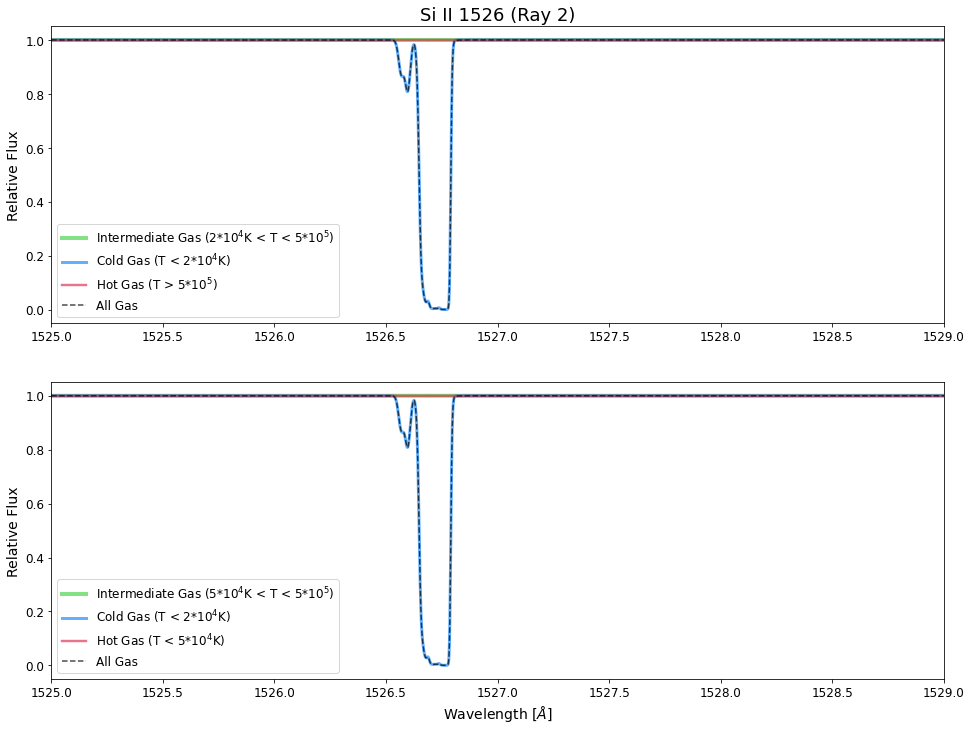

In [30]:
cut_spec(ray2, 1525, 1529, el='Si', rom_num='II', lrest=1526.7070, gamma=3.78E+08, 
     f_value=1.32E-01, DIY=True, num='2')

yt : [INFO     ] 2022-07-15 18:57:45,059 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:57:45,147 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9377.25it/s]
yt : [INFO     ] 2022-07-15 18:57:45,236 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:57:45,262 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 14/14 [00:00<00:00, 809.67it/s]
yt : [INFO     ] 2022-07-15 18:57:45,304 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:57:45,331 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 14/14 [00:00<00:00, 825.17it/s]
yt : [INFO     ] 2022-07-15 18:57:45,368 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:57:45,395 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 6/6 [00:00<00:00, 1761.70it/s]
yt : [INFO     ] 2022-07-15 18:57:45,405 Writing spectrum to a

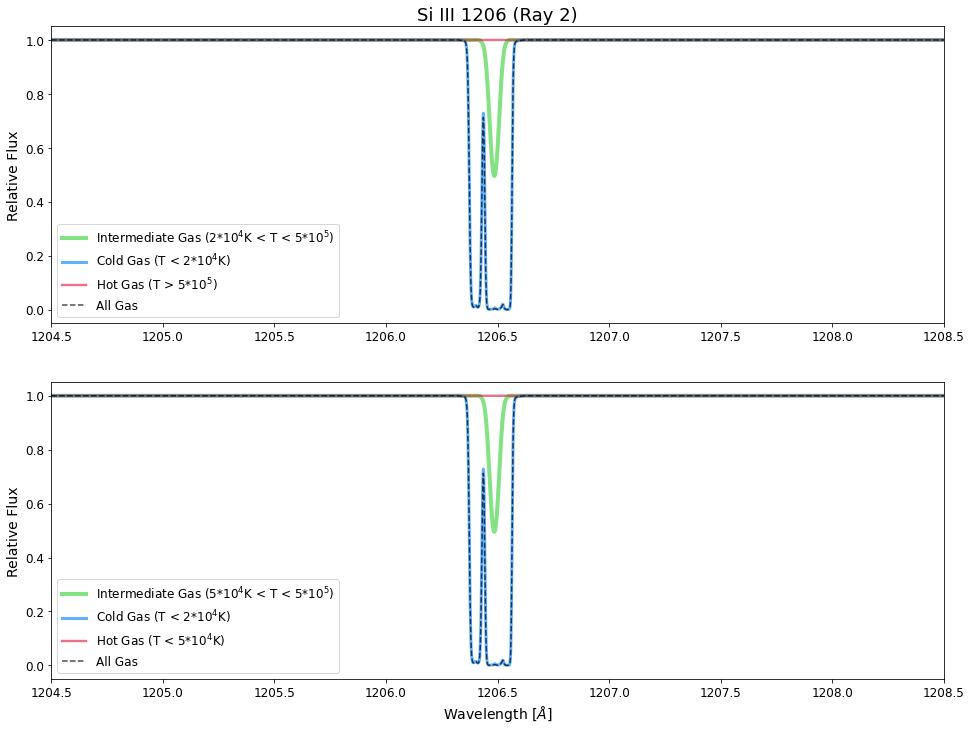

In [31]:
cut_spec(ray2, 1204.5, 1208.5, el='Si', rom_num='III', lrest=1206.5, gamma=2.57E+09, 
     f_value=1.68E+00 , DIY=True, num='2')
plt.savefig('Overleaf Plots/Si3_Temp.jpg', dpi=800)

yt : [INFO     ] 2022-07-15 18:57:57,711 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:57:57,720 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9972.71it/s]
yt : [INFO     ] 2022-07-15 18:57:57,781 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:57:57,810 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 14/14 [00:00<00:00, 1211.68it/s]
yt : [INFO     ] 2022-07-15 18:57:57,830 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:57:57,857 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 14/14 [00:00<00:00, 1178.36it/s]
yt : [INFO     ] 2022-07-15 18:57:57,872 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:57:57,900 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 6/6 [00:00<00:00, 1084.73it/s]
yt : [INFO     ] 2022-07-15 18:57:57,908 Writing spectrum to asc

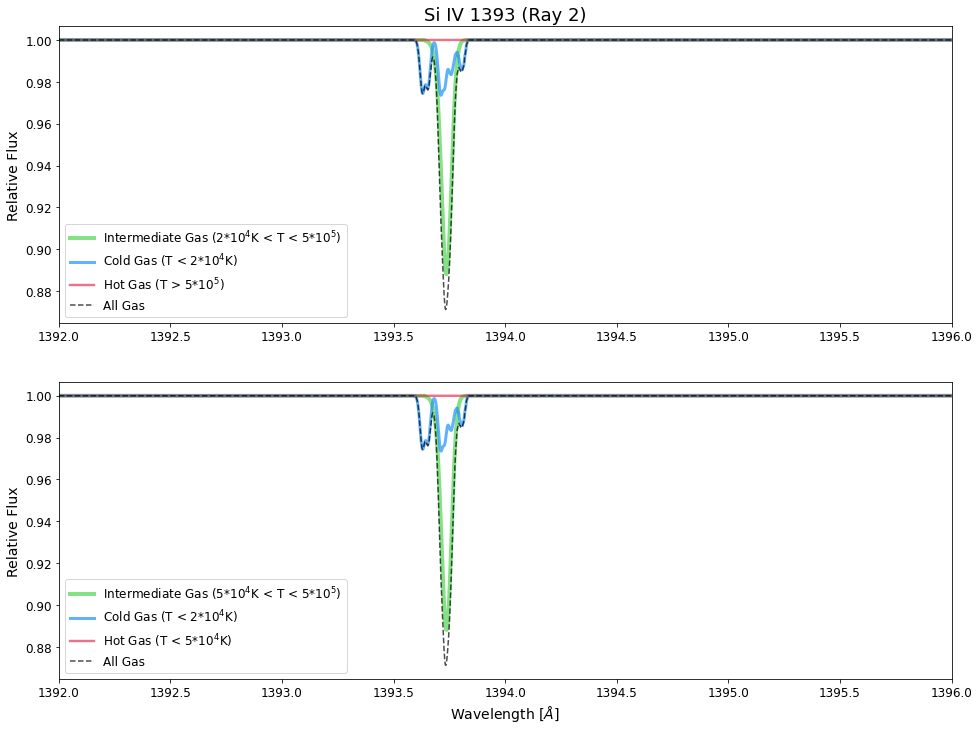

In [32]:
cut_spec(ray2, 1392, 1396, el='Si', rom_num='IV', lrest=1393.7550, gamma=9.0E+8, 
     f_value=5.24E-01, DIY=True, num='2')

yt : [INFO     ] 2022-07-15 18:58:04,318 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:58:04,330 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4473.64it/s]
yt : [INFO     ] 2022-07-15 18:58:04,437 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:58:04,463 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 40/40 [00:00<00:00, 922.89it/s]
yt : [INFO     ] 2022-07-15 18:58:04,514 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:58:04,540 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 42/42 [00:00<00:00, 896.73it/s]
yt : [INFO     ] 2022-07-15 18:58:04,589 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:58:04,616 Creating spectrum
Adding line - Si II 1526 [1526.707000 A]: : 100%|██████████| 5/5 [00:00<00:00, 2109.60it/s]
yt : [INFO     ] 2022-07-15 18:58:04,621 Writing spectrum to ascii

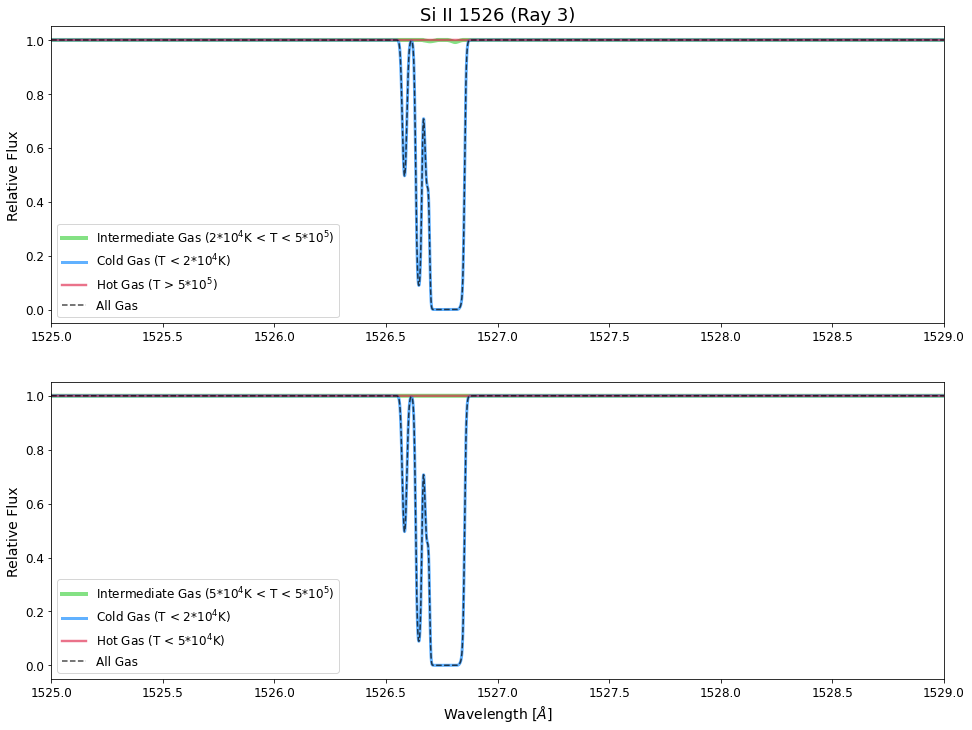

In [33]:
cut_spec(ray3, 1525, 1529, el='Si', rom_num='II', lrest=1526.7070, gamma=3.78E+08, 
     f_value=1.32E-01, DIY=True, num='3')

yt : [INFO     ] 2022-07-15 18:58:11,321 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:58:11,334 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 256/256 [00:00<00:00, 4809.23it/s]
yt : [INFO     ] 2022-07-15 18:58:11,492 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:58:11,518 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 40/40 [00:00<00:00, 954.70it/s]
yt : [INFO     ] 2022-07-15 18:58:11,606 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:58:11,633 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 42/42 [00:00<00:00, 949.60it/s]
yt : [INFO     ] 2022-07-15 18:58:11,721 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:58:11,747 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: : 100%|██████████| 5/5 [00:00<00:00, 965.18it/s]
yt : [INFO     ] 2022-07-15 18:58:11,763 Writing spectrum to as

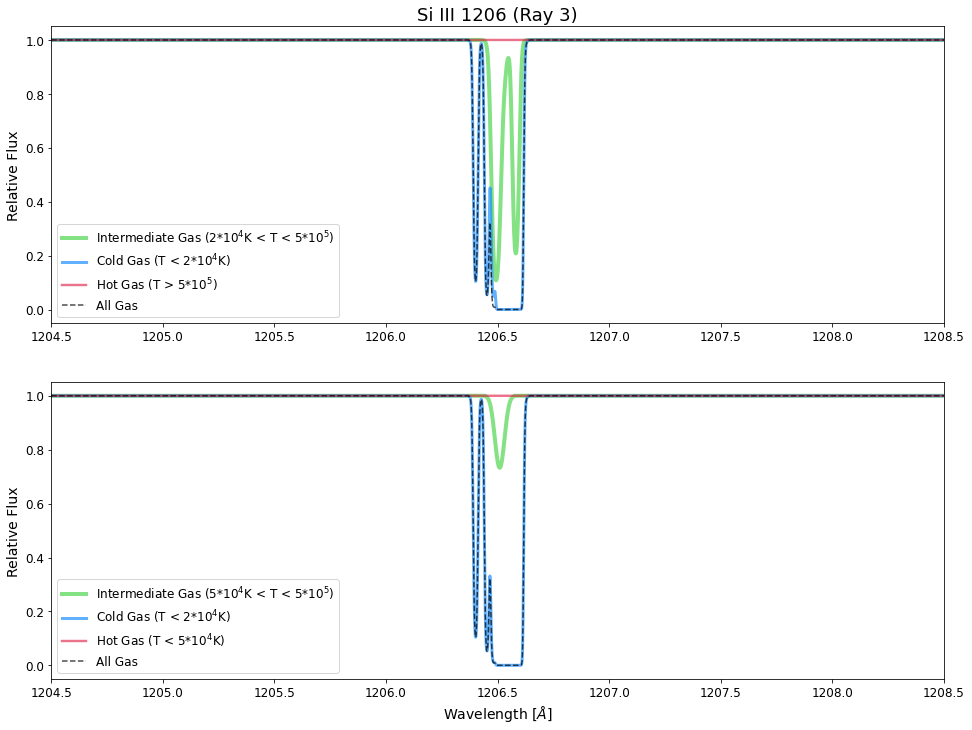

In [34]:
cut_spec(ray3, 1204.5, 1208.5, el='Si', rom_num='III', lrest=1206.5, gamma=2.57E+09, 
     f_value=1.68E+00 , DIY=True, num='3')

yt : [INFO     ] 2022-07-15 18:58:19,205 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 18:58:19,217 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 18:58:19,225 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5306.57it/s]
yt : [INFO     ] 2022-07-15 18:58:19,319 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 18:58:19,346 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 40/40 [00:00<00:00, 1203.88it/s]
yt : [INFO     ] 2022-07-15 18:58:19,386 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 18:58:19,413 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A]: : 100%|██████████| 42/42 [00:00<00:00, 1170.86it/s]
yt : [INFO     ] 2022-07-15 18:58:19,451 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 18:58:19,477 Creating spectrum
Adding line - Si IV 1393 [1393.755000 A

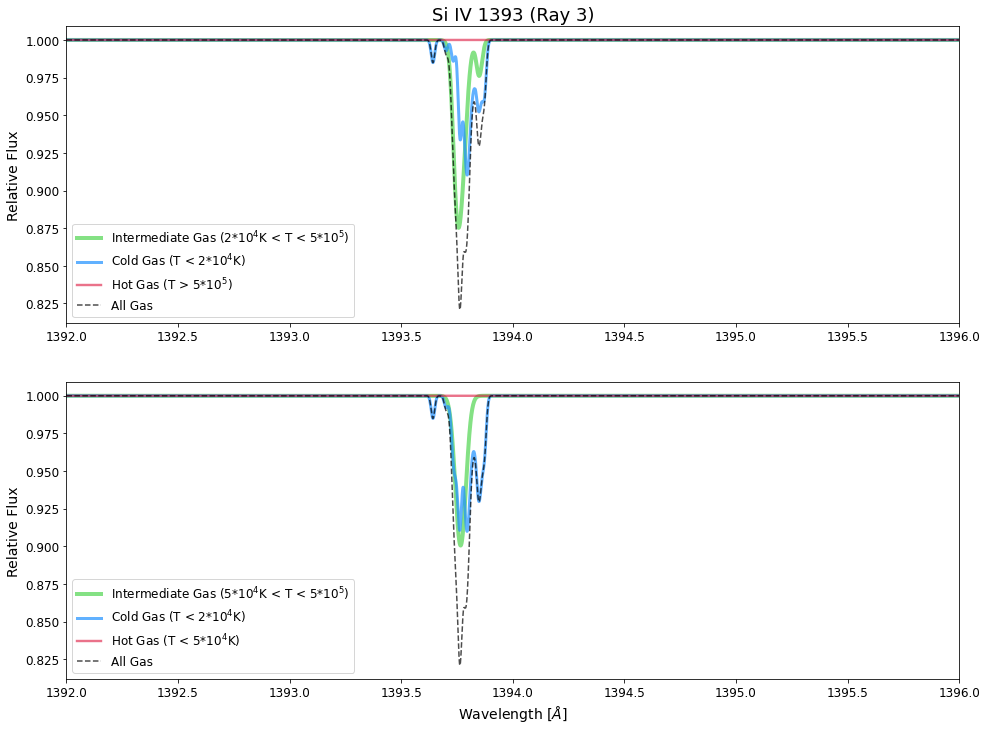

In [35]:
cut_spec(ray3, 1392, 1396, el='Si', rom_num='IV', lrest=1393.7550, gamma=9.0E+8, 
     f_value=5.24E-01, DIY=True, num='3')

yt : [INFO     ] 2022-07-15 19:00:17,618 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:00:17,628 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:00:17,659 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 256/256 [00:00<00:00, 8742.54it/s]
yt : [INFO     ] 2022-07-15 19:00:17,727 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:00:17,753 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 14/14 [00:00<00:00, 848.49it/s]
yt : [INFO     ] 2022-07-15 19:00:17,777 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:00:17,803 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 100%|██████████| 14/14 [00:00<00:00, 914.08it/s]
yt : [INFO     ] 2022-07-15 19:00:17,821 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:00:17,847 Creating spectrum
Adding line - C II 1334 [1334.532000 A]: : 10

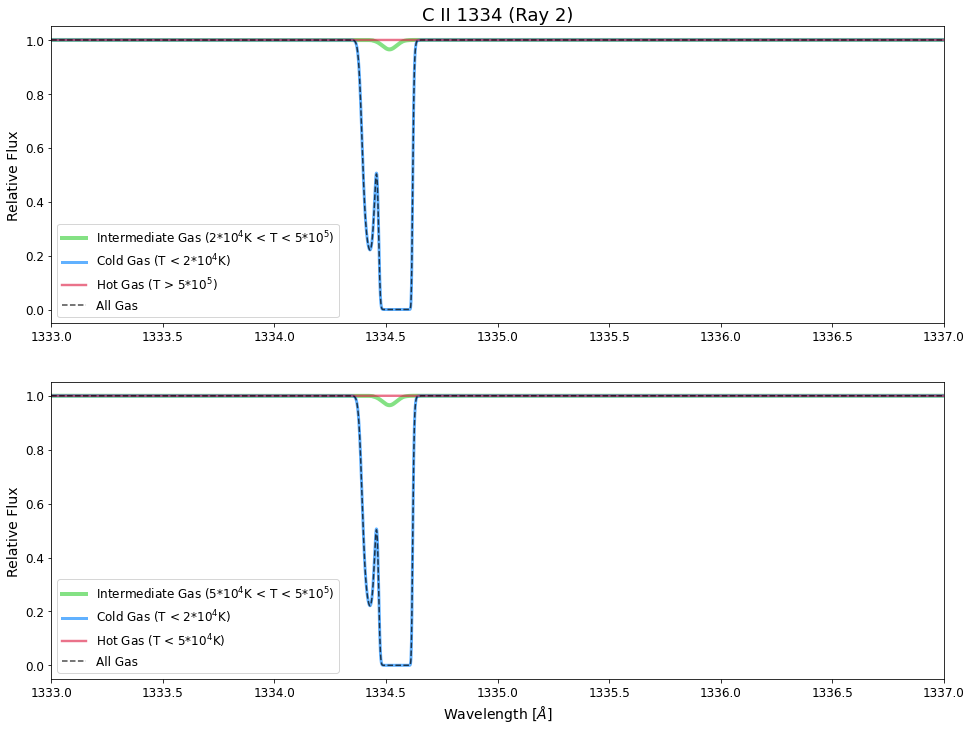

In [40]:
cut_spec(ray2, 1333, 1337, el='C', rom_num='II', lrest=1334.5320,
    gamma=2.38E+08, f_value=1.27E-01, DIY=True, num='2')

yt : [INFO     ] 2022-07-15 19:00:21,322 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:00:21,331 Creating C_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:00:21,348 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 8438.51it/s]
yt : [INFO     ] 2022-07-15 19:00:21,443 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:00:21,470 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 14/14 [00:00<00:00, 841.75it/s]
yt : [INFO     ] 2022-07-15 19:00:21,513 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:00:21,539 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 14/14 [00:00<00:00, 841.80it/s]
yt : [INFO     ] 2022-07-15 19:00:21,576 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:00:21,602 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|█

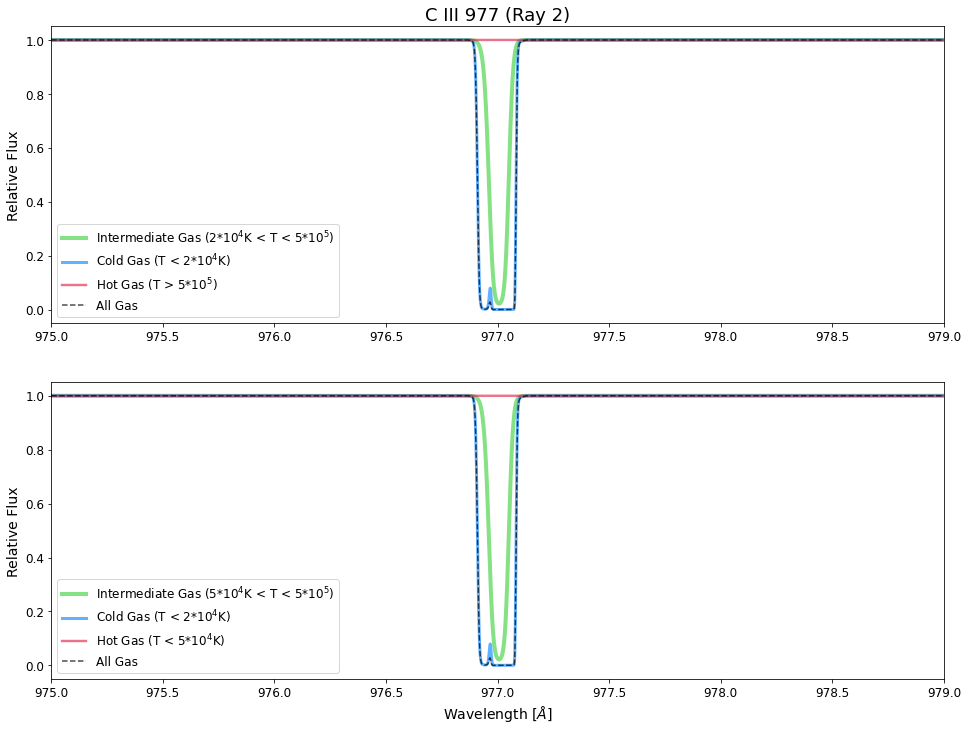

In [41]:
cut_spec(ray2, 975, 979, el='C', rom_num='III', lrest=977.0201,
    gamma=1.79E+09, f_value=7.67E-01, DIY=True, num='2')

yt : [INFO     ] 2022-07-15 19:00:36,848 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:00:36,858 Creating C_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:00:36,865 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 256/256 [00:00<00:00, 4465.14it/s]
yt : [INFO     ] 2022-07-15 19:00:37,030 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:00:37,057 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 40/40 [00:00<00:00, 906.51it/s]
yt : [INFO     ] 2022-07-15 19:00:37,153 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:00:37,179 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|██████████| 42/42 [00:00<00:00, 927.93it/s]
yt : [INFO     ] 2022-07-15 19:00:37,276 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:00:37,302 Creating spectrum
Adding line - C III 977 [977.020100 A]: : 100%|█

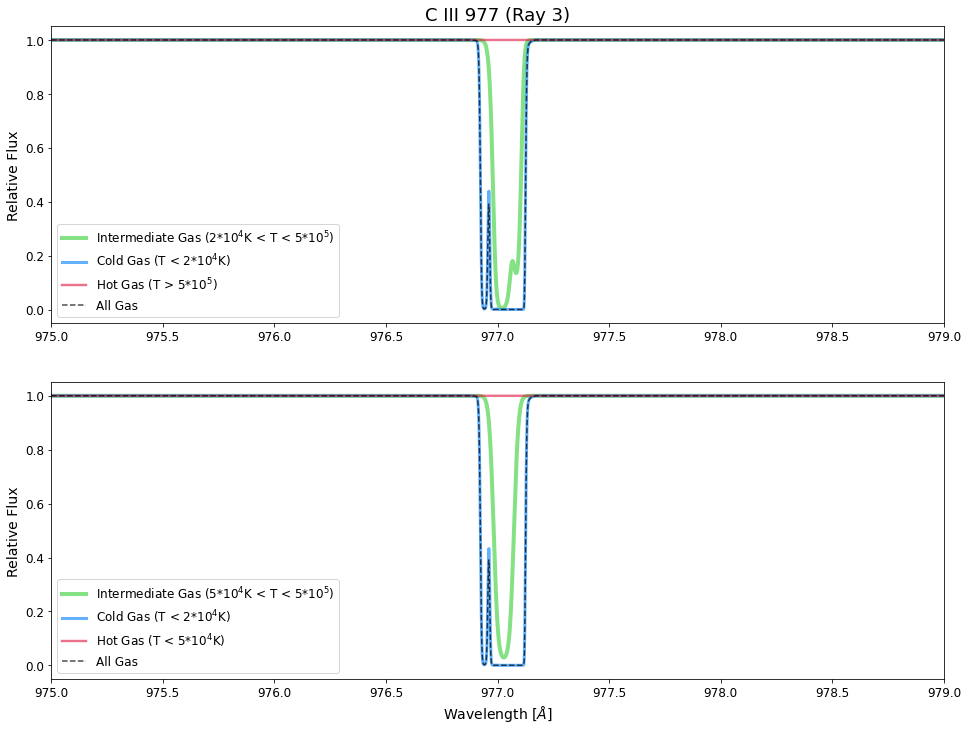

In [42]:
cut_spec(ray3, 975, 979, el='C', rom_num='III', lrest=977.0201,
    gamma=1.79E+09, f_value=7.67E-01, DIY=True, num='3')

yt : [INFO     ] 2022-07-15 19:00:44,256 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:00:44,268 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:00:44,289 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5262.82it/s]
yt : [INFO     ] 2022-07-15 19:00:44,379 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:00:44,405 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 14/14 [00:00<00:00, 3307.44it/s]
yt : [INFO     ] 2022-07-15 19:00:44,416 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:00:44,443 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 14/14 [00:00<00:00, 3237.06it/s]
yt : [INFO     ] 2022-07-15 19:00:44,449 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:00:44,475 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 

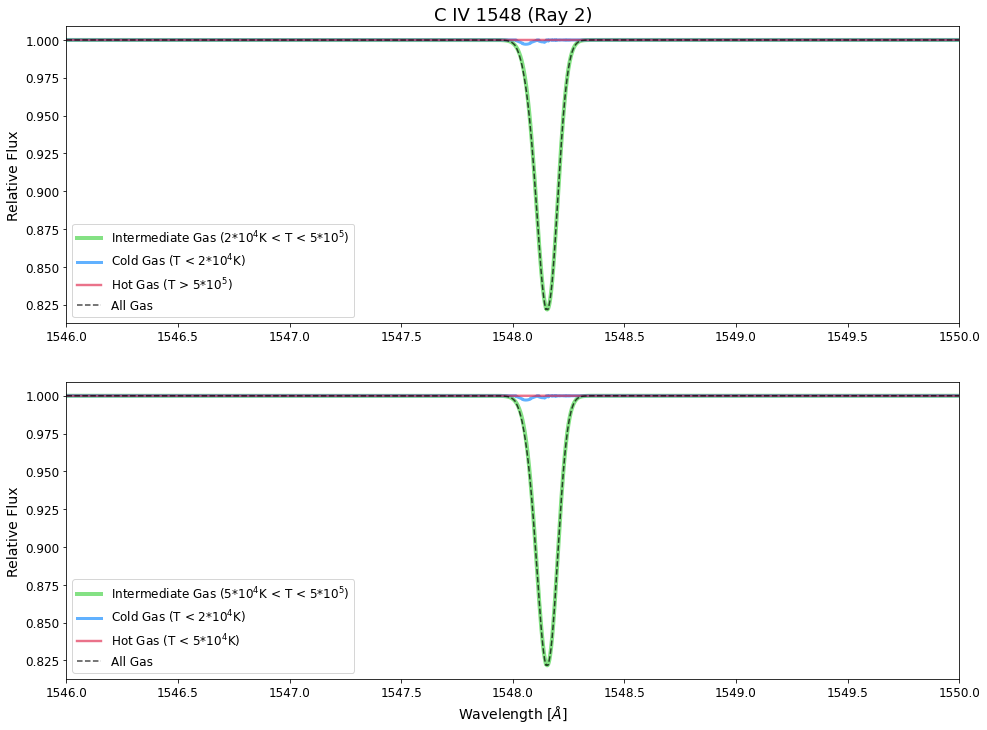

In [43]:
cut_spec(ray2, 1546, 1550, line='C IV 1548', num='2')

yt : [INFO     ] 2022-07-15 19:00:50,309 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:00:50,321 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:00:50,331 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 256/256 [00:00<00:00, 5403.59it/s]
yt : [INFO     ] 2022-07-15 19:00:50,423 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:00:50,449 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 40/40 [00:00<00:00, 5281.33it/s]
yt : [INFO     ] 2022-07-15 19:00:50,464 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:00:50,490 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 42/42 [00:00<00:00, 4171.66it/s]
yt : [INFO     ] 2022-07-15 19:00:50,502 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:00:50,529 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 

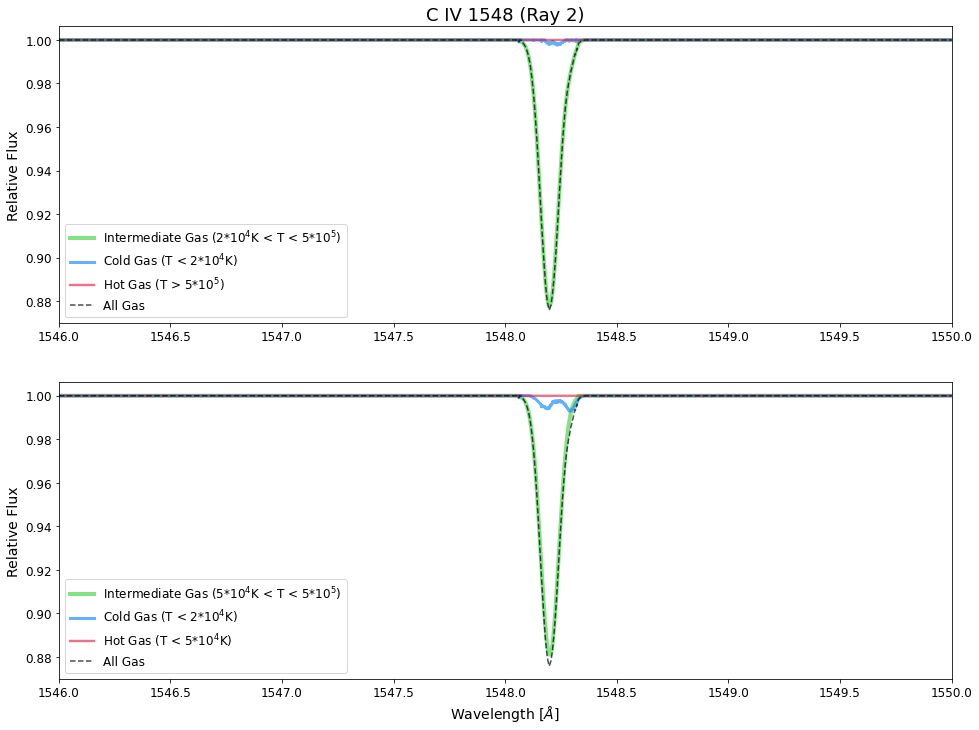

In [44]:
cut_spec(ray3, 1546, 1550, line='C IV 1548', num='2')

yt : [INFO     ] 2022-07-15 19:01:10,782 Setting instrument to Custom
yt : [INFO     ] 2022-07-15 19:01:10,792 Creating O_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2022-07-15 19:01:10,820 Creating spectrum
Adding line - O III* 835 [835.289000 A]: : 100%|██████████| 256/256 [00:00<00:00, 9796.38it/s]
yt : [INFO     ] 2022-07-15 19:01:10,913 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2022-07-15 19:01:10,939 Creating spectrum
Adding line - O III* 835 [835.289000 A]: : 100%|██████████| 14/14 [00:00<00:00, 1053.66it/s]
yt : [INFO     ] 2022-07-15 19:01:10,973 Writing spectrum to ascii file: spec_c.txt.
yt : [INFO     ] 2022-07-15 19:01:11,000 Creating spectrum
Adding line - O III* 835 [835.289000 A]: : 100%|██████████| 14/14 [00:00<00:00, 1038.95it/s]
yt : [INFO     ] 2022-07-15 19:01:11,030 Writing spectrum to ascii file: spec_c2.txt.
yt : [INFO     ] 2022-07-15 19:01:11,056 Creating spectrum
Adding line - O III* 835 [835.289000 A]: : 

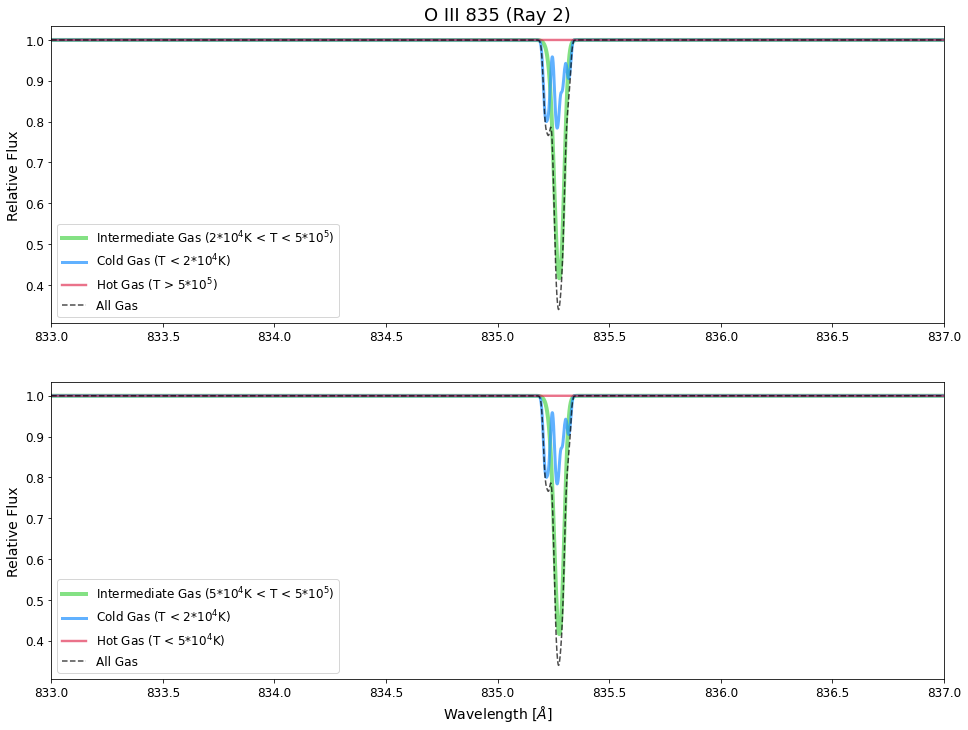

In [46]:
cut_spec(ray2, 833, 837, line='O III 835', num='2')